In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/Users/richardgrumitt/Documents/berkeley/NFMC_Jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import scipy
from scipy.stats import multivariate_normal as n_mvn
import corner
import torch
import torch.distributions as dist
import warnings
import pickle

import torch.distributions
from nfmc_jax.DLA.base import PPDLMC, LatentDLA, RegularDLA
from nfmc_jax.DLA.posterior import TorchPosterior
from nfmc_jax.DLA.debug import MultiStageDebugger
from nfmc_jax.flows.base import SINFInterface, RealNVPInterface, MAFInterface, RQNSFInterface, PPInterface
from nfmc_jax.utils.torch_distributions import gaussian_log_prob, Funnel

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)

/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# German Credit

In [2]:
data = np.genfromtxt("./fiducial_samples/german.data-numeric")
'''
x = data[:, :-1]
y = (data[:, -1] - 1).astype(np.int32)

x_min = np.min(x, 0, keepdims=True)
x_max = np.max(x, 0, keepdims=True)

x /= (x_max - x_min)
x = 2.0 * x - 1.0

x = np.concatenate([x, np.ones([x.shape[0], 1])], -1)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
'''

x = data[:, :-1]
y = (data[:, -1] - 1).astype(np.int32)
x_min = np.min(x, 0, keepdims=True)
x_max = np.max(x, 0, keepdims=True)
x /= (x_max - x_min)
x = 2.0 * x - 1.0
x = np.concatenate([x, np.ones([x.shape[0], 1])], -1)

n_dim_data = x.shape[1]
n_dim_params = 1 + n_dim_data + n_dim_data  # tau, lambdas, betas

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

print(y.shape)

torch.Size([1000, 1])


In [3]:
n = x.shape[0]
n_dim_data = x.shape[1]

'''
def log_likelihood(params, data=y, covariates=x, jitter=1e-6):
    
    log_tau = params[:, 0].reshape(params.shape[0], 1)
    log_lam = params[:, 1:n_dim_data+1]
    beta = params[:, n_dim_data+1:]

    data = torch.broadcast_to(data.reshape(data.shape[0], 1), (data.shape[0], params.shape[0]))
    
    f = torch.matmul(covariates, (torch.exp(log_tau) * beta * torch.exp(log_lam)).T)
    
    return torch.sum(torch.distributions.Bernoulli(probs=torch.clip(torch.special.expit(f),
                                                                    min=jitter,
                                                                    max=1.0-jitter)).log_prob(data), dim=0)

def log_prior(params, jitter=1e-6):
    
    log_tau = params[:, 0]
    log_lam = params[:, 1:n_dim_data+1]
    beta = params[:, n_dim_data+1:]
    logp_tau = log_tau + torch.distributions.Gamma(0.5, 0.5).log_prob(torch.clip(torch.exp(log_tau),
                                                                                 min=jitter,
                                                                                 max=1.0-jitter))
    logp_lam = torch.sum(log_lam + torch.distributions.Gamma(0.5, 0.5).log_prob(torch.clip(torch.exp(log_lam),
                                                                                           min=jitter,
                                                                                           max=1.0-jitter)), dim=1)
    #logp_beta = torch.sum(torch.distributions.Normal(loc=0.0, scale=1.0).log_prob(beta), dim=1)
    logp_beta = torch.distributions.MultivariateNormal(loc=torch.zeros(d), 
                                                       covariance_matrix=torch.eye(d)).log_prob(beta)
    
    return logp_tau + logp_lam + logp_beta
'''

def gamma_log_prob(x, alpha=0.5, beta=0.5):
    # Proportional
    return (alpha - 1) * torch.log(x) - beta * x


def log_prior(params: torch.Tensor):
    # Log prior (proportional) for a single parameter sample with shape (n_dim_params, )
    tau = params[:, 0].exp()
    lambdas = params[:, 1:1 + n_dim_data].exp()
    betas = params[:, 1 + n_dim_data:]

    tau_log_prob = dist.Gamma(0.5, 0.5).log_prob(tau) + torch.log(tau)
    lambdas_log_prob = (dist.Gamma(0.5, 0.5).log_prob(lambdas) + torch.log(lambdas)).sum(dim=-1)
    betas_log_prob = dist.Normal(0.0, 1.0).log_prob(betas).sum(dim=-1)
    '''
    tau_log_prob = torch.log(tau) + gamma_log_prob(tau)
    lambdas_log_prob = torch.sum(torch.log(lambdas), dim=1) + torch.sum(gamma_log_prob(lambdas), dim=1)
    betas_log_prob = torch.sum(gaussian_log_prob(betas), dim=1)
    '''
    
    log_prob = tau_log_prob + lambdas_log_prob + betas_log_prob
    return log_prob


def log_likelihood(params: torch.Tensor):
    # Log likelihood (proportional) for a single parameter sample with shape (n_dim_params, )
    tau = params[:, 0].exp()
    lambdas = params[:, 1:1 + n_dim_data].exp()
    betas = params[:, 1 + n_dim_data:]

    logits = x @ (tau.view(-1, 1) * betas * lambdas).T
    '''
    print(logits.shape)
    thetas = torch.clip(torch.sigmoid(x @ (tau.view(-1, 1) * betas * lambdas).T), 1e-5, 1 - 1e-5)
    log_prob = y * torch.log(thetas) + (1 - y) * torch.log(1 - thetas)
    log_prob = log_prob.sum(dim=0)
    '''
    
    #probs = torch.clip(torch.sigmoid(logits), 1e-7, 1.0 - 1e-7)
    #log_prob = y * torch.log(probs) + (1.0 - y) * torch.log(1.0 - probs)
    bern_logp = dist.Bernoulli(logits=logits).log_prob(y)
    #bern_logp = torch.sum(bern_logp, dim=0)
    
    return bern_logp.sum(dim=0)
    
def prior_rvs(N, seed):
    torch.manual_seed(seed)
    tau = dist.Gamma(0.5, 0.5).sample((N,))
    lam = dist.Gamma(0.5, 0.5).sample((N, n_dim_data))
    beta = torch.randn((N, n_dim_data))
    
    return torch.cat([torch.log(tau).reshape(N, 1), torch.log(lam), beta], dim=1)

initial_samples = prior_rvs(51, 0)

print(log_likelihood(initial_samples).shape)

posterior = TorchPosterior(log_likelihood = lambda x: log_likelihood(x),
                           log_prior = lambda x: log_prior(x))

torch.Size([51])


In [4]:
n = x.shape[0]
d = x.shape[1]

In [5]:
data_dir = '/Users/richardgrumitt/Documents/berkeley/nfmc_jax_tests/dlmc_grad_experiments/benchmarks/german_credit'

class GermanCredit:
    def __init__(self):
        # https://arxiv.org/abs/1903.03704
        # tau, lambda (25), beta (25)
        self.num_parameters = 51

        self.x = None
        self.y = None
        self.load_data()

    @property
    def num_observations(self):
        if self.x is None:
            return 0
        else:
            return len(self.x)

    def load_data(self):
        data = np.array(pd.read_table(f'{data_dir}/german-data-numeric.tsv', header=None, delim_whitespace=True)).astype(
            np.float32
        )
        x = data[:, :-1]
        y = (data[:, -1] - 1).astype(np.int32)
        x_min = np.min(x, 0, keepdims=True)
        x_max = np.max(x, 0, keepdims=True)
        x /= (x_max - x_min)
        x = 2.0 * x - 1.0
        x = np.concatenate([x, np.ones([x.shape[0], 1])], -1)

        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)  # Torch wants floats, even if we have a Bernoulli likelihood

    def log_prior(self, unconstrained_parameters: torch.Tensor):
        log_tau = unconstrained_parameters[:, 0]
        log_lmbd = unconstrained_parameters[:, 1:26]
        beta = unconstrained_parameters[:, 26:51]

        tau = torch.exp(log_tau)
        lmbd = torch.exp(log_lmbd)

        log_prob_tau = dist.Gamma(0.5, 0.5).log_prob(tau)
        log_prob_lmbd = torch.sum(dist.Gamma(0.5, 0.5).log_prob(lmbd), dim=1)
        log_prob_beta = torch.sum(dist.Normal(0, 1).log_prob(beta), dim=1)

        log_prob = log_prob_tau + log_prob_lmbd + log_prob_beta
        return log_prob

    def log_likelihood(self, unconstrained_parameters: torch.Tensor):
        log_tau = unconstrained_parameters[:, 0]
        log_lmbd = unconstrained_parameters[:, 1:26]
        beta = unconstrained_parameters[:, 26:51]

        tau = torch.exp(log_tau)
        lmbd = torch.exp(log_lmbd)

        loc = torch.sigmoid((self.x @ (tau.view(-1, 1) * beta * lmbd).T).T)
        log_prob = dist.Independent(dist.Bernoulli(loc), 1).log_prob(self.y)

        return log_prob

    def logj(self, unconstrained_parameters: torch.Tensor):
        log_tau = unconstrained_parameters[:, 0]
        log_lmbd = unconstrained_parameters[:, 1:26]

        tau = torch.exp(log_tau)
        lmbd = torch.exp(log_lmbd)
        logj_tau = log_tau
        logj_lmbd = torch.sum(log_lmbd, dim=1)

        logj = logj_tau + logj_lmbd
        return logj

    def log_posterior(self, unconstrained_parameters: torch.Tensor):
        return (
                self.log_likelihood(unconstrained_parameters) +
                self.log_prior(unconstrained_parameters) +
                self.logj(unconstrained_parameters)
        )

    @staticmethod
    def hmc():
        nuts_posterior = np.loadtxt(f'{data_dir}/german_credit_nuts_samples.txt')
        return nuts_posterior
    
gc = GermanCredit()
gc.load_data()
gc_posterior = TorchPosterior(log_likelihood = lambda x: gc.log_likelihood(x),
                              log_prior = lambda x: gc.log_prior(x) + gc.logj(x))

In [32]:
# Note - check about passing validation data to this.

flow_interface = SINFInterface()
flow_interface.create_flow(x=initial_samples,
                           val_frac=0.2,
                           iteration=None,
                           bounds=None,
                           alpha=(0.98, 0.98),
                           NBfirstlayer=True,
                           verbose=False,
                           M=None,
                           K=None,
                           maxknot=True,
                           MSWD_max_iter=None)

In [7]:
burnin_interface = SINFInterface()
burnin_interface.create_flow(x=initial_samples,
                           val_frac=0.2,
                           iteration=None,
                           bounds=None,
                           alpha=(0.98, 0.98),
                           NBfirstlayer=True,
                           verbose=False,
                           M=None,
                           maxknot=True,
                           MSWD_max_iter=None)

In [ ]:
import pickle

#idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
idx = [9]

for i in idx:
    
    print(f'DLMC run {i}')
    
    initial_samples = prior_rvs(10, i)

    dlmc = LatentDLA(interface=flow_interface,
                     burnin_interface=burnin_interface,
                     posterior=gc_posterior,
                     debugger=None
                     )

    xf = dlmc.run(initial_samples,
              main_step=0.001,
              burnin_step=0.01,
              burnin_optimizer='adagrad',
              optimizer='adagrad',
              optim_scheduler='identity',
              exp_decay_rate=0.999,
              cos_T_max=100,
              cos_lr_min=0.0,
              burnin_optim_steps=1,
              optim_steps=2,
              atol=1e-15,
              max_burnin=20,
              burnin_thresh=0.0,
              num_upsample=204 - 10,
              upsample_schedule=None,
              step_schedule=None,
              max_iterations=250,
              latent=True,
              IMHstep=1,
              CMHstep=0,
              CMHscale=0.1,
              ULMstep=0,
              stochastic_calibration=False,
              taylor_zeta=True,
              use_tqdm=True,
              post_ulm_steps=0,
              post_ulm_batch=0,
              animate_kwargs=dict(dpi=200),
              train_kwargs={'val_frac': 0.2},
              underdamped_kwargs={'step_size':1.0e-3, 'gamma': 2.0}
                  )
    
    with open(f'./dlmc_grad_experiments/benchmarks/german_credit/nuts/dlmc_run_{i}.pkl', 'wb') as f:
        pickle.dump(xf, f)
    f.close()

DLMC run 9


  0%|                                                   | 0/270 [00:00<?, ?it/s]

zVirial = 4782.890625
Virial = 4647.8740234375
<sum_x_virial> = 4647.8740234375
<sum_z_virial> = 4782.890625


[Stage 0] Beta: 1.0:   0%|      | 1/270 [00:03<13:52,  3.10s/it, accept_IMH=0.7]

zVirial = 2377.443115234375
Virial = 1802.9599609375
<sum_x_virial> = 1802.9599609375
<sum_z_virial> = 2377.443115234375


[Stage 0] Beta: 1.0:   1%|      | 3/270 [00:05<07:23,  1.66s/it, accept_IMH=0.6]

zVirial = 1846.4188232421875
Virial = 1311.1475830078125
<sum_x_virial> = 1311.1475830078125
<sum_z_virial> = 1846.4188232421875


[Stage 0] Beta: 1.0:   1%|      | 4/270 [00:06<06:09,  1.39s/it, accept_IMH=0.3]

zVirial = 1023.0353393554688
Virial = 693.6096801757812
<sum_x_virial> = 693.6096801757812
<sum_z_virial> = 1023.0353393554688


[Stage 0] Beta: 1.0:   2%|      | 5/270 [00:07<05:15,  1.19s/it, accept_IMH=0.1]

zVirial = 483.6741943359375
Virial = 282.4659729003906
<sum_x_virial> = 282.4659729003906
<sum_z_virial> = 483.6741943359375


[Stage 0] Beta: 1.0:   2%|      | 5/270 [00:08<05:15,  1.19s/it, accept_IMH=0.1]

zVirial = 187.08453369140625
Virial = 60.995750427246094
<sum_x_virial> = 60.995750427246094
<sum_z_virial> = 187.08453369140625


[Stage 0] Beta: 1.0:   3%|▏     | 7/270 [00:09<04:52,  1.11s/it, accept_IMH=0.1]

zVirial = 137.4846954345703
Virial = 61.097286224365234
<sum_x_virial> = 61.097286224365234
<sum_z_virial> = 137.4846954345703


[Stage 0] Beta: 1.0:   3%|▏     | 7/270 [00:10<04:52,  1.11s/it, accept_IMH=0.2]

zVirial = 652.1765747070312
Virial = 125.593994140625
<sum_x_virial> = 125.593994140625
<sum_z_virial> = 652.1765747070312


[Stage 0] Beta: 1.0:   3%|▏     | 9/270 [00:11<04:11,  1.04it/s, accept_IMH=0.1]

zVirial = 145.4227752685547
Virial = 91.07181549072266
<sum_x_virial> = 91.07181549072266
<sum_z_virial> = 145.4227752685547


[Stage 0] Beta: 1.0:   4%|▎      | 10/270 [00:12<03:58,  1.09it/s, accept_IMH=0]

zVirial = 149.71583557128906
Virial = 68.99082946777344
<sum_x_virial> = 68.99082946777344
<sum_z_virial> = 149.71583557128906


[Stage 0] Beta: 1.0:   4%|▎      | 11/270 [00:13<03:57,  1.09it/s, accept_IMH=0]

zVirial = 183.98898315429688
Virial = 68.8028335571289
<sum_x_virial> = 68.8028335571289
<sum_z_virial> = 183.98898315429688


[Stage 0] Beta: 1.0:   4%|▎      | 11/270 [00:14<03:57,  1.09it/s, accept_IMH=0]

zVirial = 153.1759796142578
Virial = 66.71623229980469
<sum_x_virial> = 66.71623229980469
<sum_z_virial> = 153.1759796142578


[Stage 0] Beta: 1.0:   5%|▏    | 13/270 [00:15<04:17,  1.00s/it, accept_IMH=0.3]

zVirial = 137.51651000976562
Virial = 62.96299743652344
<sum_x_virial> = 62.96299743652344
<sum_z_virial> = 137.51651000976562


[Stage 0] Beta: 1.0:   5%|▎      | 14/270 [00:15<03:47,  1.13it/s, accept_IMH=0]

zVirial = 12.29845142364502
Virial = 57.422142028808594
<sum_x_virial> = 57.422142028808594
<sum_z_virial> = 12.29845142364502
zVirial = 236.05580139160156
Virial = 53.912353515625
<sum_x_virial> = 53.912353515625
<sum_z_virial> = 236.05580139160156


[Stage 0] Beta: 1.0:   6%|▎    | 15/270 [00:18<04:28,  1.05s/it, accept_IMH=0.3]

zVirial = 226.4942626953125
Virial = 54.23213577270508
<sum_x_virial> = 54.23213577270508
<sum_z_virial> = 226.4942626953125


[Stage 0] Beta: 1.0:   6%|▎    | 16/270 [00:18<04:34,  1.08s/it, accept_IMH=0.3]

zVirial = 241.3323516845703
Virial = 60.650001525878906
<sum_x_virial> = 60.650001525878906
<sum_z_virial> = 241.3323516845703


[Stage 0] Beta: 1.0:   7%|▍      | 18/270 [00:20<04:12,  1.00s/it, accept_IMH=0]

zVirial = -70.1450424194336
Virial = 58.81538009643555
<sum_x_virial> = 58.81538009643555
<sum_z_virial> = -70.1450424194336


[Stage 0] Beta: 1.0:   7%|▍      | 19/270 [00:21<04:11,  1.00s/it, accept_IMH=0]

zVirial = 29.985437393188477
Virial = 55.86121368408203
<sum_x_virial> = 55.86121368408203
<sum_z_virial> = 29.985437393188477
Reached maximum number of burnin iterations.
Drawing 194 new particles from current q for post-burnin DLMC.
<sum_x_virial> = 679.82080078125
<sum_z_virial> = 780.8251342773438


[Stage 0] Beta: 1.0:   7%|▏  | 20/270 [00:31<15:16,  3.67s/it, accept_IMH=0.451]

<sum_x_virial> = 191.02943420410156
<sum_z_virial> = 249.85971069335938


[Stage 0] Beta: 1.0:   8%|▏  | 21/270 [00:40<21:43,  5.24s/it, accept_IMH=0.343]

<sum_x_virial> = 105.2008056640625
<sum_z_virial> = -24.205293655395508


[Stage 0] Beta: 1.0:   8%|▎   | 22/270 [00:52<30:45,  7.44s/it, accept_IMH=0.23]

In [55]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

In [56]:
num_runs = 10
bench_dir = './dlmc_grad_experiments/benchmarks/german_credit/nuts/'

hmc_data = az.from_netcdf(f'{bench_dir}inference_data_german_credit_mcmc.nc')
tuning_steps = np.loadtxt(f'{bench_dir}german_credit_warmup_n_steps.txt')

hmc_steps = hmc_data['sample_stats']['n_steps'].to_numpy()
hmc_tau = hmc_data['posterior']['tau'].to_numpy()
hmc_lam = hmc_data['posterior']['lam'].to_numpy()
hmc_beta = hmc_data['posterior']['beta'].to_numpy()

hmc_samples = np.concatenate([hmc_tau.reshape(hmc_tau.shape[0], hmc_tau.shape[1], 1),
                              hmc_lam, hmc_beta], axis=2)

hmc_log_samples = np.concatenate([np.log(hmc_tau).reshape(hmc_tau.shape[0], hmc_tau.shape[1], 1),
                                  np.log(hmc_lam), hmc_beta], axis=2)

print(hmc_log_samples.shape)

ref_samples = np.loadtxt(f'{bench_dir}german_credit_samples.txt')

(10, 10000, 51)


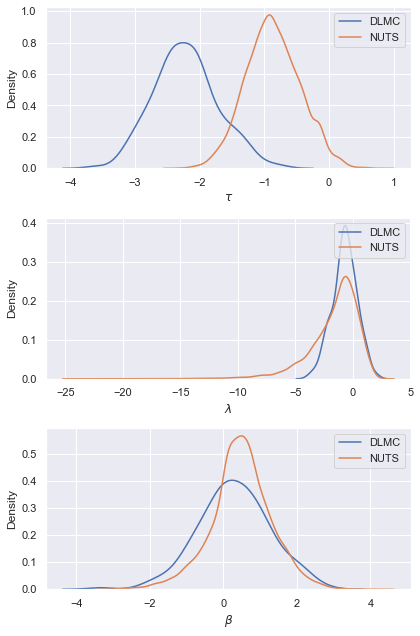

In [57]:

sns.set_theme()
fig = plt.figure(figsize=(2 * 2 * 1.5, 2 * 1.5 * 3))
plt.subplot(3, 1, 1)
sns.kdeplot(xf[0][:, 0], label='DLMC')
sns.kdeplot(hmc_log_samples[0, :, 0], label='NUTS')
plt.xlabel(r'$\tau$')
plt.legend(loc='upper right')
plt.subplot(3, 1, 2)
sns.kdeplot(xf[0][:, 4], label='DLMC')
sns.kdeplot(hmc_log_samples[0, :, 4], label='NUTS')
plt.xlabel(r'$\lambda$')
#plt.xlim(0, 3)
plt.legend(loc='upper right')
plt.subplot(3, 1, 3)
sns.kdeplot(xf[0][:, 44], label='DLMC')
sns.kdeplot(hmc_log_samples[0, :, 44], label='NUTS')
plt.xlabel(r'$\beta$')
plt.legend(loc='upper right')
plt.tight_layout()

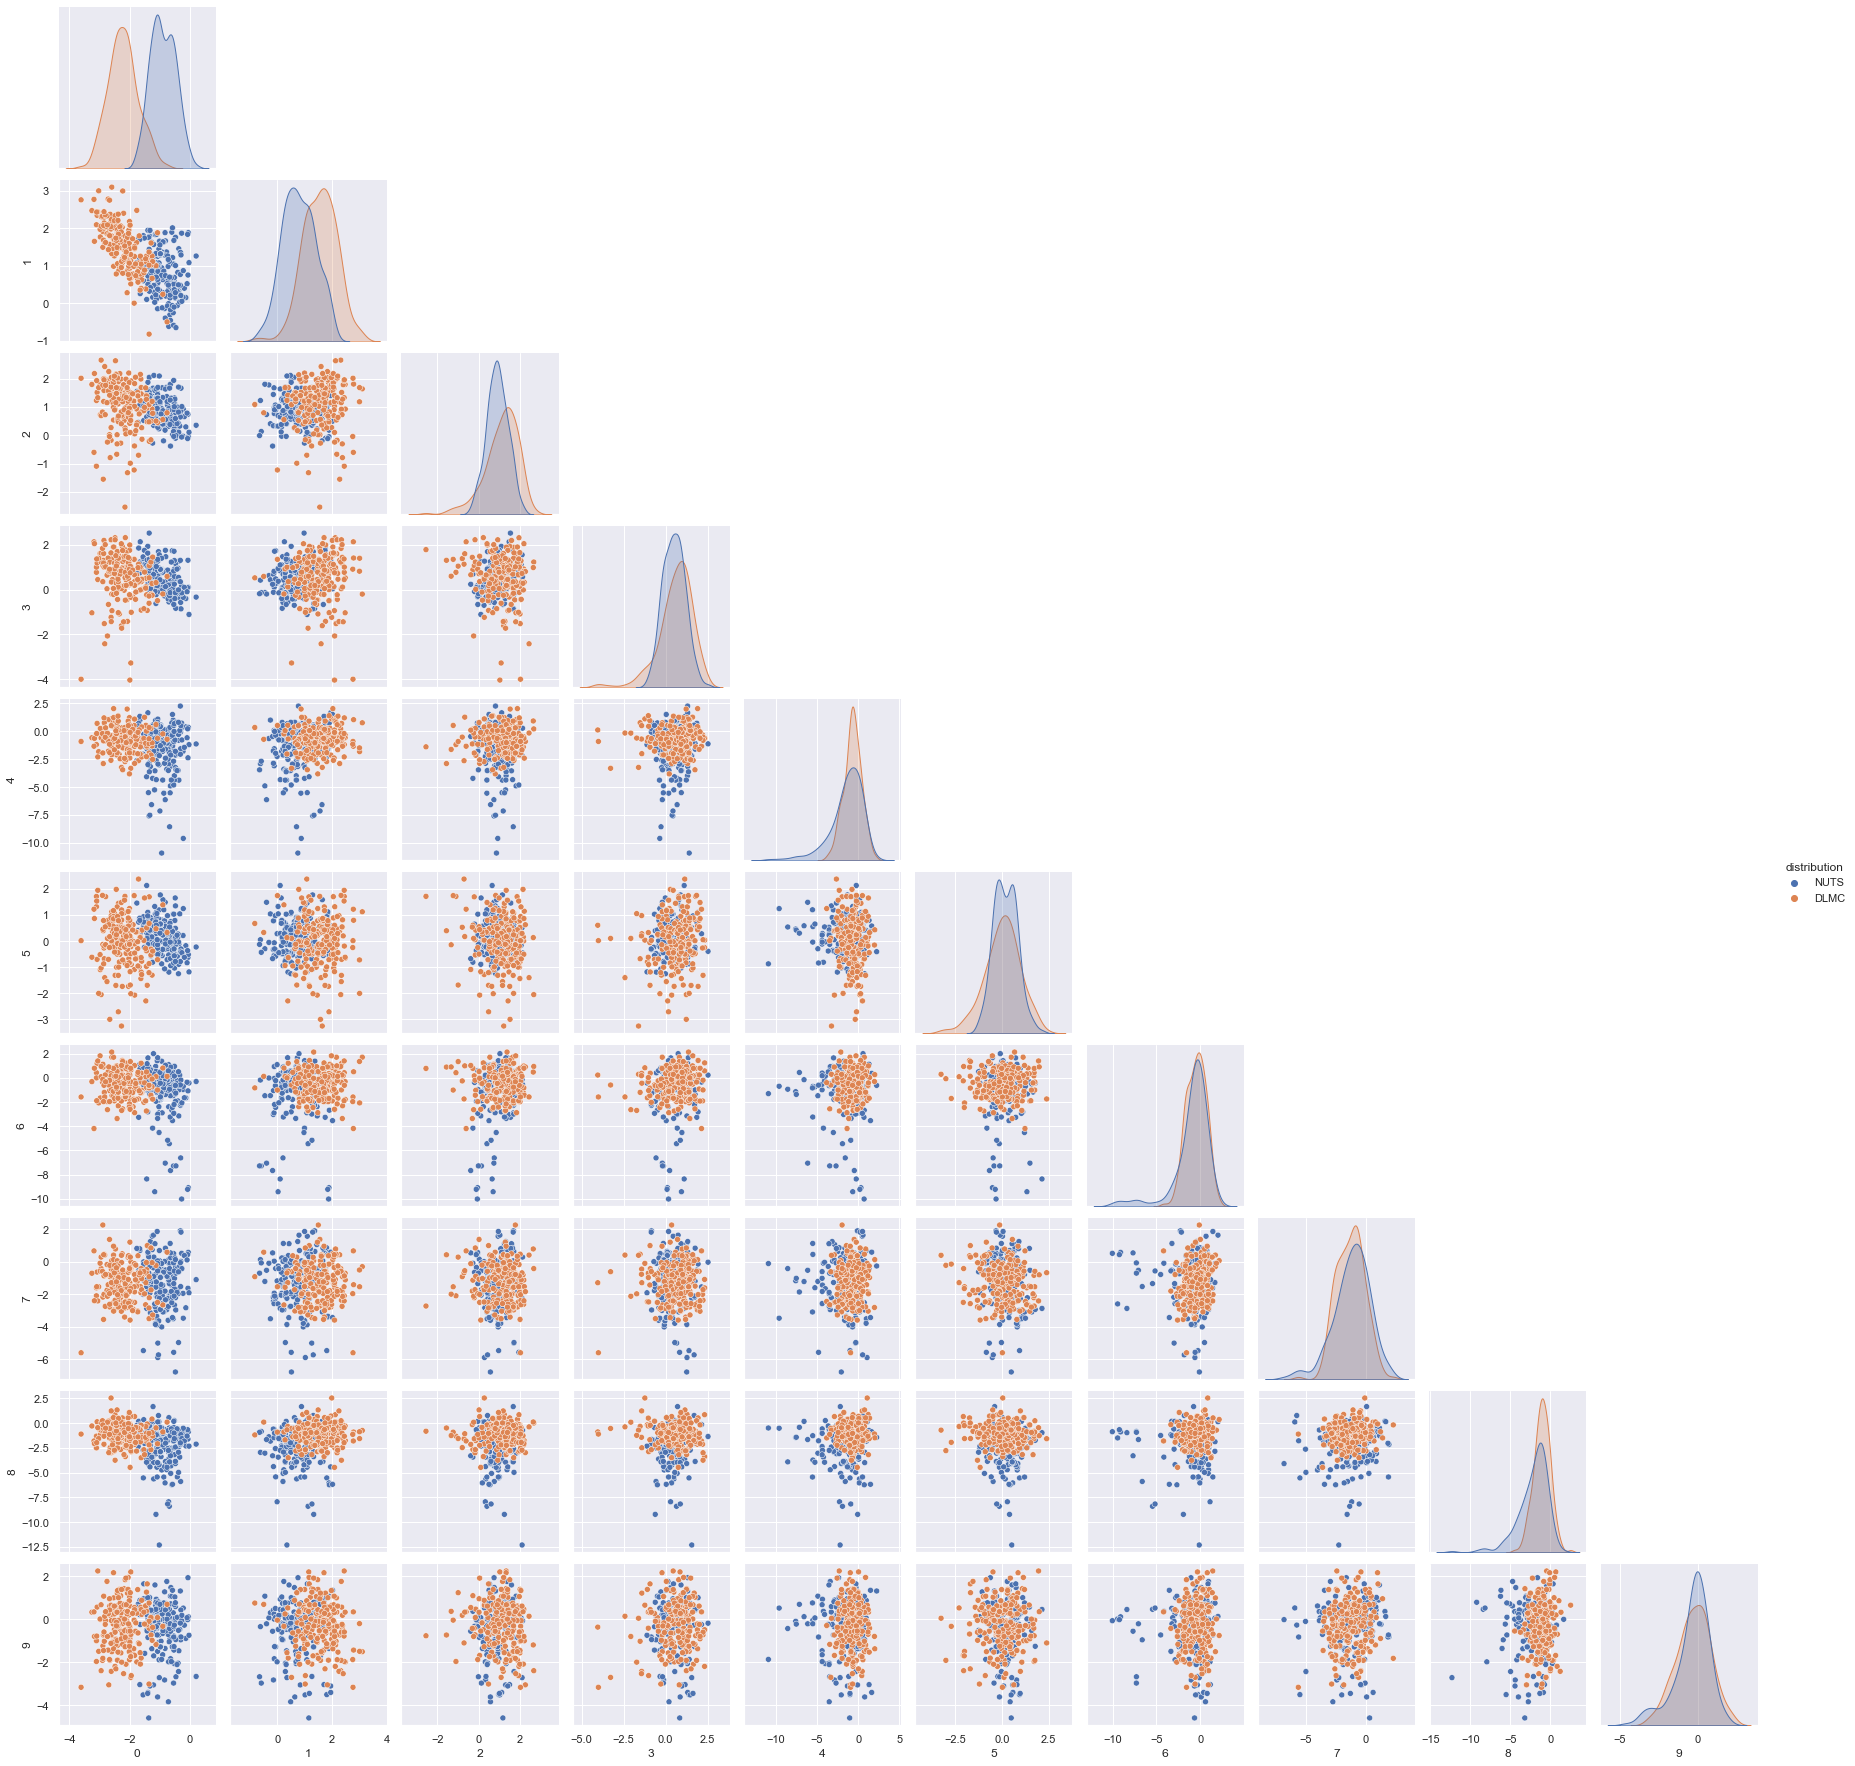

In [58]:
nuts_posterior = np.loadtxt(f'{data_dir}/german_credit_nuts_samples.txt')
log_normalized_posterior = np.copy(nuts_posterior)
log_normalized_posterior[:, :26] = np.log(log_normalized_posterior[:, :26])

df = pd.concat([
    pd.DataFrame(hmc_log_samples[0, :len(xf[0]), :10]),
    pd.DataFrame(xf[0][:, :10].numpy()),
]).reset_index(drop=True)
df['distribution'] = ['NUTS'] * len(xf[0]) + \
                     ['DLMC'] * len(xf[0])

sns.pairplot(df, corner=True, hue='distribution')

10


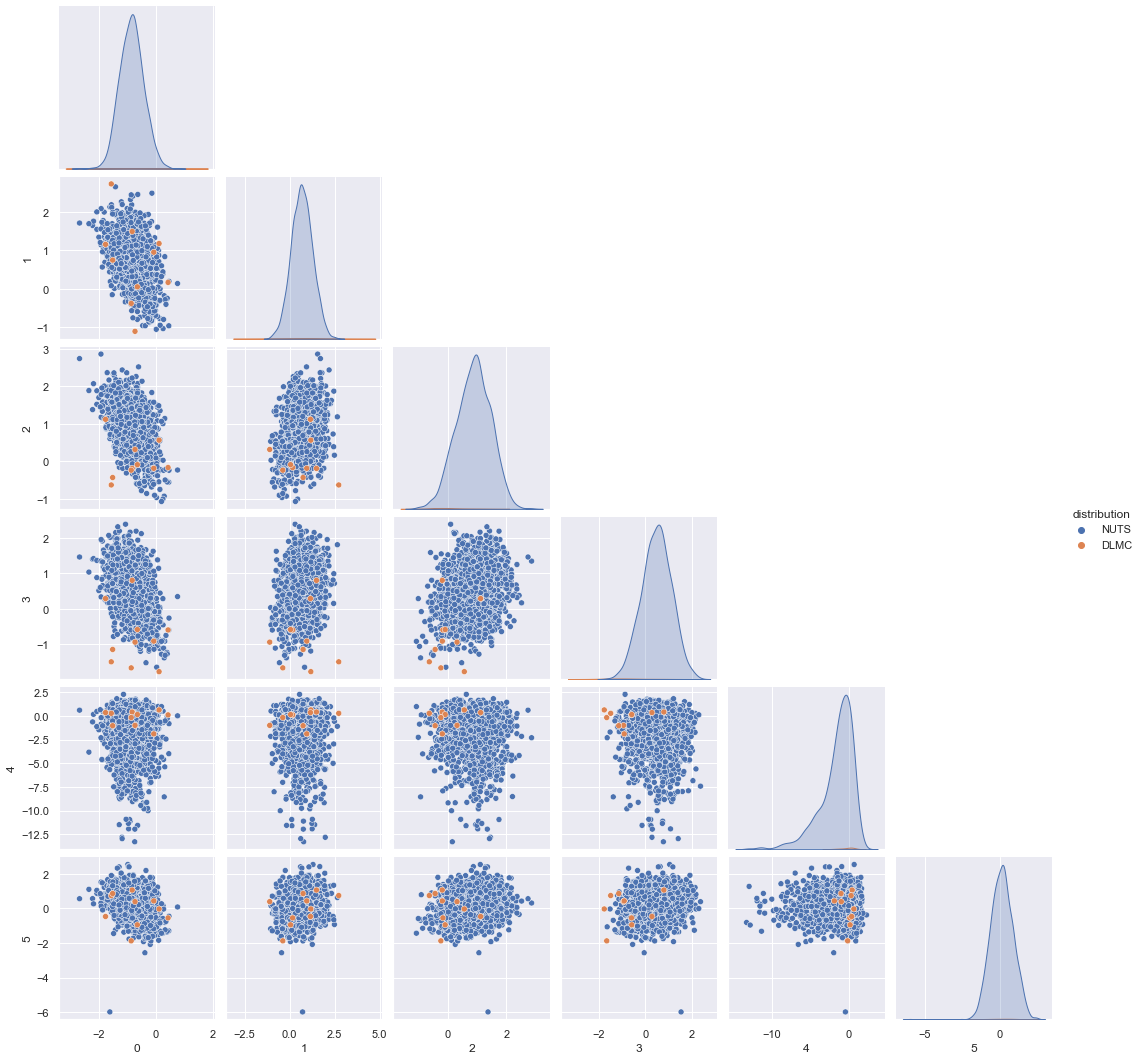

In [98]:
nuts_posterior = np.loadtxt('./fiducial_samples/german_credit_nuts_samples.txt')
log_normalized_posterior = np.copy(nuts_posterior)
log_normalized_posterior[:, :26] = np.log(log_normalized_posterior[:, :26])

samples = xf[2]['20']
print(len(xf[1]['8']))


df = pd.concat([
    pd.DataFrame(log_normalized_posterior[:, :6]),
    pd.DataFrame(samples[:, :6].numpy()),
]).reset_index(drop=True)
df['distribution'] = ['NUTS'] * len(log_normalized_posterior) + \
                     ['DLMC'] * len(samples)

sns.pairplot(df, corner=True, hue='distribution')

In [64]:
def sns_pairplot(q_samples, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(truth_samples)] = truth_label
        labels[len(truth_samples):] = q_label
        x_samples = np.concatenate([truth_samples, q_samples])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, common_norm=False, levels=levels)
    g.map_offdiag(sns.scatterplot, size=0.01, alpha=0.5)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

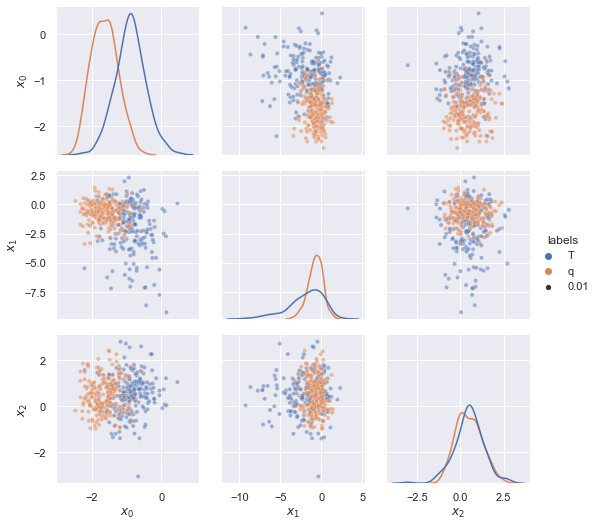

In [69]:
sns_pairplot(xf[1]['89'][:, np.array([0, 10, 44])], log_normalized_posterior[:4*51, np.array([0, 10, 44])])

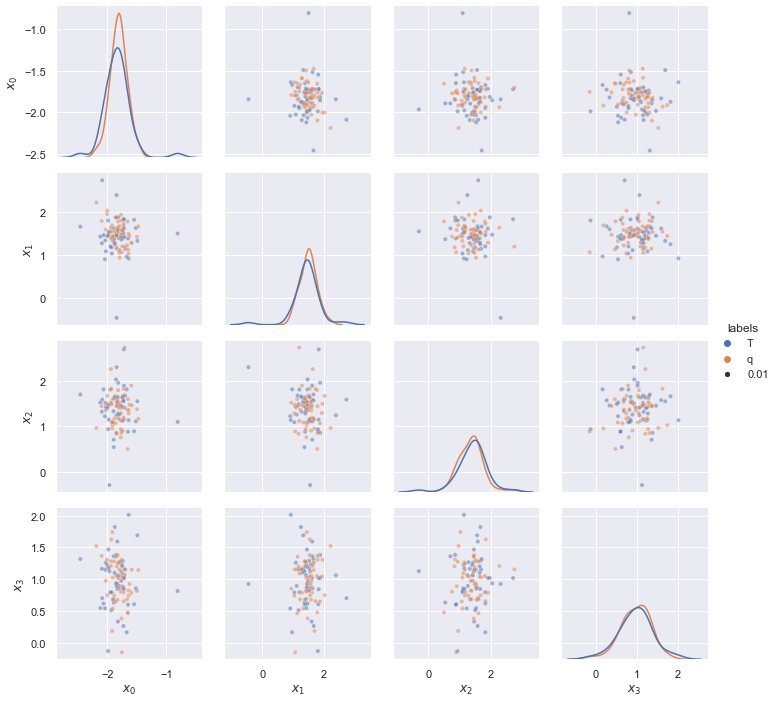

In [125]:
sns_pairplot(xf[1]['298'][:, :4], xf[2]['298'][:, :4])

# Bias analysis

In [13]:
num_runs = 10
bench_dir = './dlmc_grad_experiments/benchmarks/german_credit/nuts/'

In [52]:
hmc_data = az.from_netcdf(f'{bench_dir}inference_data_german_credit_mcmc.nc')
tuning_steps = np.loadtxt(f'{bench_dir}german_credit_warmup_n_steps.txt')

hmc_steps = hmc_data['sample_stats']['n_steps'].to_numpy()
hmc_tau = hmc_data['posterior']['tau'].to_numpy()
hmc_lam = hmc_data['posterior']['lam'].to_numpy()
hmc_beta = hmc_data['posterior']['beta'].to_numpy()

hmc_samples = np.concatenate([np.log(hmc_tau).reshape(hmc_tau.shape[0], hmc_tau.shape[1], 1),
                              np.log(hmc_lam), hmc_beta], axis=2)

print(np.var(hmc_samples[0, :, 0]))

ref_samples = np.loadtxt(f'{bench_dir}german_credit_samples.txt')
ref_samples[:, 0:(n_dim_data + 1)] = np.log(ref_samples[:, 0:(n_dim_data + 1)])
ref_var = np.var(ref_samples, axis=0)
ref_mu = np.mean(ref_samples, axis=0)

print(np.var(ref_samples[:, 0]))
print(ref_var)
print(ref_mu)

0.17890024
0.18258024857891192
[0.18258025 0.35163512 0.33660313 0.42082291 4.90013767 0.55009646
 3.42255221 4.10723995 4.91969322 2.15662536 4.59487186 2.80796972
 4.78642675 5.11145603 5.21029665 3.81955914 1.16952171 0.93758815
 3.33140793 4.44232874 4.14635659 4.58663555 4.69323936 5.11902332
 5.26819709 3.85805756 0.32479832 0.33267019 0.31743367 0.74517318
 0.32018722 0.5163762  0.58161878 0.66704967 0.41168302 0.66684296
 0.44783482 0.69635084 0.65991628 0.63289528 0.60121771 0.33886126
 0.33623771 0.5148966  0.68399169 0.58860877 0.6265598  0.71156751
 0.66521372 0.6667277  0.71602009]
[-0.85753225  0.66074788  0.86147044  0.4961556  -1.61250366  0.15379977
 -1.07933613 -1.35939901 -2.45100885 -0.51172192 -1.56906188 -0.99395849
 -1.76191842 -2.4562396  -2.49969639 -0.95576256 -0.35759311  0.16561214
 -0.90580458 -1.28513875 -1.60619825 -1.87614512 -1.61746844 -2.44519449
 -2.61809459 -0.44687063 -1.15400416  1.25261493 -1.08408527  0.29913983
 -0.96860722 -0.62757526 -0.52314

# S.D. Bias Squared ...

Mean tuning steps = 106936.5


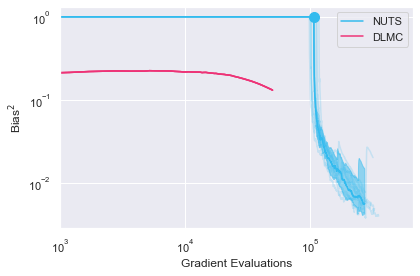

In [53]:
total_tuning = np.sum(tuning_steps, axis=1)
mean_total_tuning = np.mean(total_tuning)
print(f'Mean tuning steps = {mean_total_tuning}')

max_nuts = 1000
num_tuning = 500
num_dlmc = 100
num_dlmc_tuning = 20
dlmc_particles = 500
dlmc_tuning_particles = 10 * 1

all_hmc_bias_sq = np.empty((num_runs, max_nuts))
all_hmc_cum_steps = np.empty((num_runs, max_nuts))
all_tuning_steps = np.empty((num_runs, num_tuning))

all_dlmc_bias_sq = np.empty((num_runs, num_dlmc + num_dlmc_tuning))

plt.figure()
sns.set_theme()
for i in range(num_runs):
    
    all_hmc_cum_steps[i, :] = np.cumsum(hmc_steps[i, :max_nuts])
    all_tuning_steps[i, :] = np.cumsum(tuning_steps[i, :])
    hmc_cum_steps = np.cumsum(np.concatenate([tuning_steps[i, :], hmc_steps[i, :max_nuts]]))
    hmc_bias_sq = []
    #hmc_samples[i, :, 0:(n_dim_data + 1)] = np.log(hmc_samples[i, :, 0:(n_dim_data + 1)])
    for j in range(1, max_nuts + 1):
        iter_var = np.var(hmc_samples[i, :j, :], axis=0)
        iter_bias_sq = (np.sqrt(iter_var) - np.sqrt(ref_var)) ** 2 / ref_var
        #iter_bias_sq = (iter_var - ref_var) ** 2
        hmc_bias_sq.append(np.mean(iter_bias_sq))
    hmc_bias_sq = np.array(hmc_bias_sq)
    all_hmc_bias_sq[i, :] = hmc_bias_sq
    hmc_bias_sq = np.concatenate([hmc_bias_sq[0] * np.ones(len(tuning_steps[i, :])), hmc_bias_sq])
        
    with open(f'./dlmc_grad_experiments/benchmarks/german_credit/nuts/dlmc_run_{9}.pkl', 'rb') as f:
        dlmc_x = pickle.load(f)
    
    dlmc_bias_sq = []
    for k in range(0, num_dlmc + num_dlmc_tuning):
        if k == 0:
            iter_dlmc_x = dlmc_x[1]['init'].numpy()
            #iter_dlmc_x[:, 0:(n_dim_data + 1)] = np.exp(iter_dlmc_x[:, 0:(n_dim_data + 1)])
            dlmc_var = np.var(iter_dlmc_x, axis=0)
        else:
            iter_dlmc_x = dlmc_x[1][f'{k - 1}'].numpy()
            #iter_dlmc_x[:, 0:(n_dim_data + 1)] = np.exp(iter_dlmc_x[:, 0:(n_dim_data + 1)])
            dlmc_var = np.var(iter_dlmc_x, axis=0)
        bias2 = (np.sqrt(dlmc_var) - np.sqrt(ref_var)) ** 2 / ref_var
        #bias2 = (dlmc_var - ref_var) ** 2
        dlmc_bias_sq.append(np.mean(bias2))
    all_dlmc_bias_sq[i, :] = np.array(dlmc_bias_sq)
    #all_dlmc_bias_sq[i, :num_dlmc_tuning] = all_dlmc_bias_sq[i, num_dlmc_tuning]
    dlmc_steps = dlmc_tuning_particles * np.ones(num_dlmc_tuning)
    dlmc_steps = np.concatenate([dlmc_steps, dlmc_particles * np.ones(num_dlmc)])
    dlmc_steps = np.cumsum(dlmc_steps)
    
    plt.plot(hmc_cum_steps, hmc_bias_sq, color='#33BBEE', alpha=0.2)
    plt.plot(dlmc_steps, np.array(dlmc_bias_sq), color='#EE3377', alpha=0.2)

mean_tuning_steps = np.median(all_tuning_steps, axis=0)
mean_hmc_cum_steps = np.median(all_hmc_cum_steps, axis=0) + mean_tuning_steps[-1:]
mean_nuts_steps = np.concatenate([mean_tuning_steps, mean_hmc_cum_steps])
mean_hmc_bias_sq = np.median(all_hmc_bias_sq, axis=0)
mean_nuts_bias_sq = np.concatenate([mean_hmc_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                    mean_hmc_bias_sq])

low_hmc_bias_sq = np.percentile(all_hmc_bias_sq, 5, axis=0)
high_hmc_bias_sq = np.percentile(all_hmc_bias_sq, 95, axis=0)
low_nuts_bias_sq = np.concatenate([low_hmc_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                   low_hmc_bias_sq])
high_nuts_bias_sq = np.concatenate([high_hmc_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                    high_hmc_bias_sq])

mean_dlmc_bias_sq = np.median(all_dlmc_bias_sq, axis=0)
low_dlmc_bias_sq = np.percentile(all_dlmc_bias_sq, 5, axis=0)
high_dlmc_bias_sq = np.percentile(all_dlmc_bias_sq, 95, axis=0)
    
plt.plot(mean_nuts_steps, mean_nuts_bias_sq, label='NUTS', color='#33BBEE')
plt.plot(dlmc_steps, mean_dlmc_bias_sq, label='DLMC', color='#EE3377')
plt.plot(mean_tuning_steps[-1:], mean_hmc_bias_sq[0], marker='o', markersize=10, color='#33BBEE')
plt.fill_between(mean_nuts_steps, low_nuts_bias_sq, high_nuts_bias_sq, color='#33BBEE', alpha=0.5)
plt.fill_between(dlmc_steps, low_dlmc_bias_sq, high_dlmc_bias_sq, color='#EE3377', alpha=0.5)
    
plt.loglog()
plt.legend(loc='upper right')
plt.xlim(1000)
plt.ylabel(r'Bias$^2$')
plt.xlabel('Gradient Evaluations')
plt.tight_layout()
plt.savefig(f'./dlmc_grad_experiments/benchmarks/german_credit/nuts/bias2_german_credit_95percentiles.png', dpi=300)

# Bias Squared Mean

Mean tuning steps = 106936.5


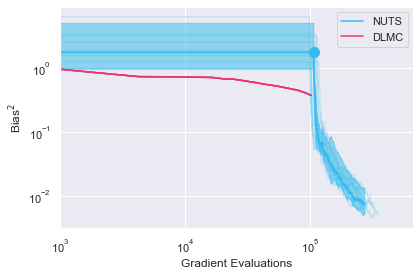

In [16]:
total_tuning = np.sum(tuning_steps, axis=1)
mean_total_tuning = np.mean(total_tuning)
print(f'Mean tuning steps = {mean_total_tuning}')

max_nuts = 1000
num_tuning = 500
num_dlmc = 25
num_dlmc_tuning = 20
dlmc_particles = 102 * 40
dlmc_tuning_particles = 10 * 1

all_hmc_bias_sq = np.empty((num_runs, max_nuts))
all_hmc_cum_steps = np.empty((num_runs, max_nuts))
all_tuning_steps = np.empty((num_runs, num_tuning))

all_dlmc_bias_sq = np.empty((num_runs, num_dlmc + num_dlmc_tuning))

plt.figure()
sns.set_theme()
for i in range(num_runs):
    
    all_hmc_cum_steps[i, :] = np.cumsum(hmc_steps[i, :max_nuts])
    all_tuning_steps[i, :] = np.cumsum(tuning_steps[i, :])
    hmc_cum_steps = np.cumsum(np.concatenate([tuning_steps[i, :], hmc_steps[i, :max_nuts]]))
    hmc_bias_sq = []
    #hmc_samples[i, :, 0:(n_dim_data + 1)] = np.log(hmc_samples[i, :, 0:(n_dim_data + 1)])
    for j in range(1, max_nuts + 1):
        iter_mu = np.mean(hmc_samples[i, :j, :], axis=0)
        iter_bias_sq = (iter_mu - ref_mu) ** 2
        hmc_bias_sq.append(np.mean(iter_bias_sq))
    hmc_bias_sq = np.array(hmc_bias_sq)
    all_hmc_bias_sq[i, :] = hmc_bias_sq
    hmc_bias_sq = np.concatenate([hmc_bias_sq[0] * np.ones(len(tuning_steps[i, :])), hmc_bias_sq])
        
    with open(f'./dlmc_grad_experiments/benchmarks/german_credit/nuts/dlmc_run_{9}.pkl', 'rb') as f:
        dlmc_x = pickle.load(f)
    
    dlmc_bias_sq = []
    for k in range(0, num_dlmc + num_dlmc_tuning):
        if k == 0:
            iter_dlmc_x = dlmc_x[1]['init'].numpy()
            #iter_dlmc_x[:, 0:(n_dim_data + 1)] = np.exp(iter_dlmc_x[:, 0:(n_dim_data + 1)])
            dlmc_mu = np.mean(iter_dlmc_x, axis=0)
        else:
            iter_dlmc_x = dlmc_x[1][f'{k - 1}'].numpy()
            #iter_dlmc_x[:, 0:(n_dim_data + 1)] = np.exp(iter_dlmc_x[:, 0:(n_dim_data + 1)])
            dlmc_mu = np.mean(iter_dlmc_x, axis=0)
        bias2 = (dlmc_mu - ref_mu) ** 2
        dlmc_bias_sq.append(np.mean(bias2))
    all_dlmc_bias_sq[i, :] = np.array(dlmc_bias_sq)
    #all_dlmc_bias_sq[i, :num_dlmc_tuning] = all_dlmc_bias_sq[i, num_dlmc_tuning]
    dlmc_steps = dlmc_tuning_particles * np.ones(num_dlmc_tuning)
    dlmc_steps = np.concatenate([dlmc_steps, dlmc_particles * np.ones(num_dlmc)])
    dlmc_steps = np.cumsum(dlmc_steps)
    
    plt.plot(hmc_cum_steps, hmc_bias_sq, color='#33BBEE', alpha=0.2)
    plt.plot(dlmc_steps, np.array(dlmc_bias_sq), color='#EE3377', alpha=0.2)

mean_tuning_steps = np.median(all_tuning_steps, axis=0)
mean_hmc_cum_steps = np.median(all_hmc_cum_steps, axis=0) + mean_tuning_steps[-1:]
mean_nuts_steps = np.concatenate([mean_tuning_steps, mean_hmc_cum_steps])
mean_hmc_bias_sq = np.median(all_hmc_bias_sq, axis=0)
mean_nuts_bias_sq = np.concatenate([mean_hmc_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                    mean_hmc_bias_sq])

low_hmc_bias_sq = np.percentile(all_hmc_bias_sq, 5, axis=0)
high_hmc_bias_sq = np.percentile(all_hmc_bias_sq, 95, axis=0)
low_nuts_bias_sq = np.concatenate([low_hmc_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                   low_hmc_bias_sq])
high_nuts_bias_sq = np.concatenate([high_hmc_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                    high_hmc_bias_sq])

mean_dlmc_bias_sq = np.median(all_dlmc_bias_sq, axis=0)
low_dlmc_bias_sq = np.percentile(all_dlmc_bias_sq, 5, axis=0)
high_dlmc_bias_sq = np.percentile(all_dlmc_bias_sq, 95, axis=0)
    
plt.plot(mean_nuts_steps, mean_nuts_bias_sq, label='NUTS', color='#33BBEE')
plt.plot(dlmc_steps, mean_dlmc_bias_sq, label='DLMC', color='#EE3377')
plt.plot(mean_tuning_steps[-1:], mean_hmc_bias_sq[0], marker='o', markersize=10, color='#33BBEE')
plt.fill_between(mean_nuts_steps, low_nuts_bias_sq, high_nuts_bias_sq, color='#33BBEE', alpha=0.5)
plt.fill_between(dlmc_steps, low_dlmc_bias_sq, high_dlmc_bias_sq, color='#EE3377', alpha=0.5)
    
plt.loglog()
plt.legend(loc='upper right')
plt.xlim(1000)
plt.ylabel(r'Bias$^2$')
plt.xlabel('Gradient Evaluations')
plt.tight_layout()

[]

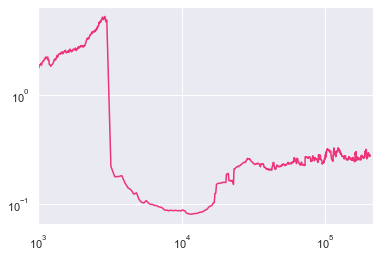

In [82]:
num_dlmc = 1300

for i in range(1, 2):
    
    with open(f'./dlmc_grad_experiments/benchmarks/german_credit/nuts/dlmc_run_{9}.pkl', 'rb') as f:
        dlmc_x = pickle.load(f)
    
    dlmc_bias_sq = []
    for k in range(0, num_dlmc):
        if k == 0:
            iter_dlmc_x = dlmc_x[1]['init'].numpy()
            iter_dlmc_x[:, 0:(n_dim_data + 1)] = iter_dlmc_x[:, 0:(n_dim_data + 1)]
            dlmc_var = np.var(iter_dlmc_x, axis=0)
        else:
            iter_dlmc_x = dlmc_x[1][f'{k - 1}'].numpy()
            iter_dlmc_x[:, 0:(n_dim_data + 1)] = iter_dlmc_x[:, 0:(n_dim_data + 1)]
            dlmc_var = np.var(iter_dlmc_x, axis=0)
        bias2 = (np.sqrt(dlmc_var) - np.sqrt(ref_var)) ** 2 / ref_var
        dlmc_bias_sq.append(np.mean(bias2))
    dlmc_steps = 204 * np.ones(num_dlmc)
    dlmc_steps[:300] = 10
    dlmc_steps = np.cumsum(dlmc_steps)

    plt.plot(dlmc_steps, np.array(dlmc_bias_sq), color='#EE3377')
 
plt.xlim(1000)
plt.loglog()

[]

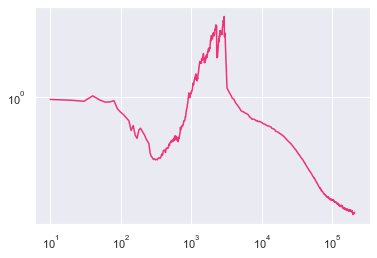

In [68]:
num_dlmc = 1300

for i in range(1, 2):
    
    with open(f'./dlmc_grad_experiments/benchmarks/german_credit/nuts/dlmc_run_{9}.pkl', 'rb') as f:
        dlmc_x = pickle.load(f)
    
    dlmc_bias_sq = []
    for k in range(0, num_dlmc):
        if k == 0:
            iter_dlmc_x = dlmc_x[1]['init'].numpy()
            iter_dlmc_x[:, 0:(n_dim_data + 1)] = iter_dlmc_x[:, 0:(n_dim_data + 1)]
            dlmc_mu = np.mean(iter_dlmc_x, axis=0)
        else:
            iter_dlmc_x = dlmc_x[1][f'{k - 1}'].numpy()
            iter_dlmc_x[:, 0:(n_dim_data + 1)] = iter_dlmc_x[:, 0:(n_dim_data + 1)]
            dlmc_mu = np.mean(iter_dlmc_x, axis=0)
        bias2 = (dlmc_mu - ref_mu) ** 2
        dlmc_bias_sq.append(np.mean(bias2))
    dlmc_steps = 204 * np.ones(num_dlmc)
    dlmc_steps[:300] = 10
    dlmc_steps = np.cumsum(dlmc_steps)

    plt.plot(dlmc_steps, np.array(dlmc_bias_sq), color='#EE3377')
    
plt.loglog()

(array([715]),)

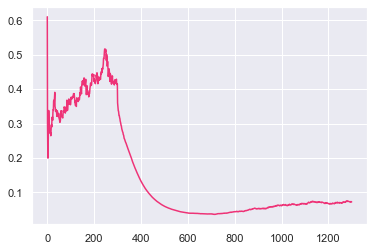

In [61]:
plt.plot(np.arange(len(dlmc_steps)), np.array(dlmc_bias_sq), color='#EE3377')
np.where(np.array(dlmc_bias_sq) == np.amin(np.array(dlmc_bias_sq)))